# Using the Waveform.jl package to set up and solve a simple 2D Full Waveform Inversion problem

In [1]:
using Pkg
check_installed_pkgs = false

Pkg.Registry.add(RegistrySpec(url="https://Github.com/slimgroup/SLIMregistryJL.git"))

# Install the auxilary packages besides Waveform.jl, if needed
if check_installed_pkgs
    pkgs = Pkg.installed()
    # JOLI - Linear operator toolbox 
    if !("JOLI" in keys(pkgs))    
        Pkg.add("JOLI")
    end
    
    # PyPlot - plotting results
    if !("PyPlot" in keys(pkgs))
        Pkg.add("PyPlot")
    end

    # OptimPackNextGen - for the SPG algorithm (you can use your own if you have one)
    if !("JUDI" in keys(pkgs))    
        Pkg.add("JUDI.jl")
    end
end

    Cloning registry from "https://Github.com/slimgroup/SLIMregistryJL.git"


Fetching: [========================================>]  100.0 %[===========>                             ]  25.2 %]  50.1 % [===============================>         ]  75.3 %

registry `SLIMregistryJL` already exist in `~/.julia/registries/SLIMregistryJL`.


In [2]:
using JOLI
using PyPlot, LinearAlgebra, Statistics
using JUDI.SLIM_optim
using WAVEFORM


┌ Info: Precompiling JUDI [f3b833dc-6b2e-5b9c-b940-873ed6319979]
└ @ Base loading.jl:1278


In [3]:
# Set up the model geometry 
# In 2D, we organize our coordinates as (z,x) for legacy + visualization purposes

# Number of gridpoints in z-, x-
n = [101;101];

# Spacing of gridpoints in z-, x-
d = 10.0*[1;1];

# Origin point of domain in z-, x- (typically (0.,0.))
o = 0.0*[1;1];

# Constant velocity background
vel_background = 2500;

# Source wavelet time shift (in seconds)
t0 = 0.0;

# Peak frequency of Ricker Wavelet (in Hz)
f0 = 10.0;

# Units of the model 
unit = "m/s";

# Model domain range
L = n.*d;

# x-coordinates of the sources 
xsrc = 0.0:50.0:L[2];

# y-coordinates of the sources (irrelevant in 2D)
ysrc = [0.0];

# z-coordinates of the sources 
zsrc = [10.0];

# x-coordinates of the receivers
xrec = 0.0:10.0:L[2];

# y-coordinates of the receivers (irrelevant in 2D)
yrec = [0.0];

# z-coordinates of the receivers (this is a transmission experiment)
zrec = [950.0];

# Frequencies to compute 
freqs = [5.0;10.0;15.0];

# Maximum wavelength
λ = vel_background/maximum(freqs);

# Model type 
model = Model{Int64,Float64}(n,d,o,t0,f0,unit,freqs,xsrc,ysrc,zsrc,xrec,yrec,zrec);
(z,x) = odn_to_grid(o,d,n);
nsrc,nrec,nfreq = length(xsrc),length(xrec),length(freqs)

# Set up computational parameters
## Size/spacing of computational domain 
comp_n = n;
comp_d = d;
comp_o = o;

# Number of PML points
npml = round(Int,λ/minimum(comp_d))*[1 1; 1 1];

# PDE scheme
scheme = WAVEFORM.helm2d_chen9p;

# Whether to remove elements in the PML when restricting to the model domain (if false, will use stacking)
cut_pml = true;

# If true, use an implicit matrix representation (false for 2D, the matrices are small enough to form explicitly)
implicit_matrix = false;

# Binary mask of the sources and frequencies to compute 
srcfreqmask = trues(nsrc,nfreq);

# Misfit function for the objective
misfit = least_squares;

# Linear solver options 
lsopts = LinSolveOpts(solver=:lufact);

# Computational options type
opts = PDEopts{Int64,Float64}(scheme,comp_n,comp_d,comp_o,cut_pml,implicit_matrix,npml,misfit,srcfreqmask,lsopts);

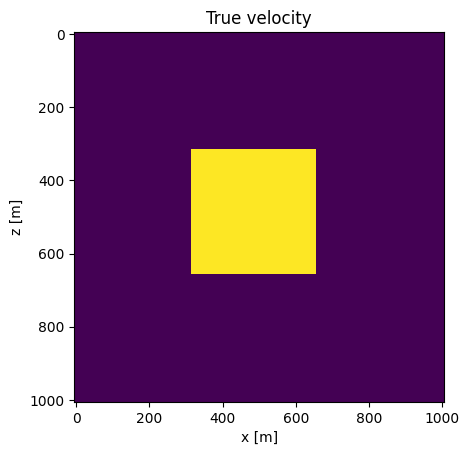

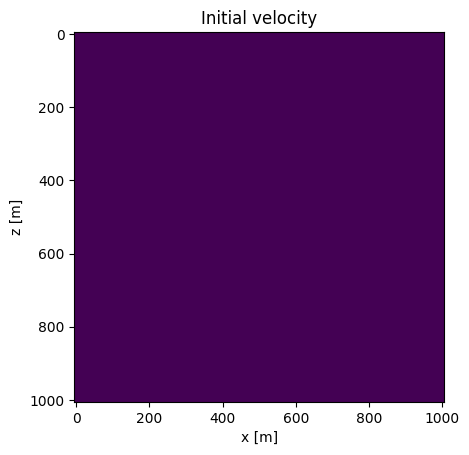

In [4]:
# Create velocity model
v0 = vel_background*ones(n...); 
v = copy(v0);
v[div(n[1],3):2*div(n[1],3),div(n[2],3):2*div(n[2],3)] .= 1.25*vel_background;
v = vec(v);
v0 = vec(v0);

function plot_velocity(vs,title_str,model)
    fig = figure()
    vplot = imshow(reshape(vs,model.n...),vmin=minimum(v),vmax=maximum(v))    
    title(title_str)
    xlabel("x [m]")
    ylabel("z [m]")
    zt = 0:20:n[1]
    xt = 0:20:n[2]
    xticks(xt,round.(Int,xt*model.d[2]))
    yticks(zt,round.(Int,zt*model.d[1]))
    return nothing
end
plot_velocity(v,"True velocity",model)
plot_velocity(v0,"Initial velocity",model)


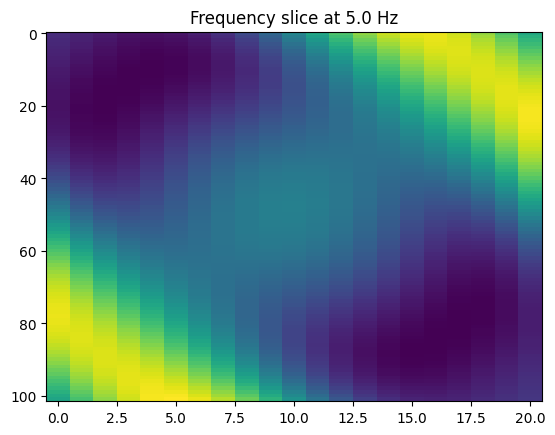

PyObject Text(0.5, 1.0, 'Frequency slice at 5.0 Hz')

In [5]:
# Source weight matrix
Q = Matrix{Float64}(I, nsrc, nsrc);

# Generate data
D = forw_model(v,Q,model,opts);

imshow(real(D[:,1:nsrc]),aspect="auto");
title("Frequency slice at $(model.freq[1]) Hz")

Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of function evaluations: 10
SPG optimality tolerance: 1.00e-05
SPG progress tolerance: 1.00e-07
 Iteration   FunEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0     0.00000e+00     0.00000e+00     5.38359e+05     1.87699e+00
         1          2          4     1.00000e+00     1.33192e+02     8.97463e+04     6.22992e-01
         2          3          7     1.00000e+00     1.64489e+02     3.21970e+04     3.24078e-01
         3          4         10     1.00000e+00     2.06714e+02     2.28343e+04     2.29533e-01
         4          5         13     1.00000e+00     4.66376e+02     1.39358e+04     1.49735e-01
Halving Step Size
         5          7         16     5.00000e-01     6.59121e+02     1.14501e+04     1.66689e-01
         6          8         19     1.00000e+00     1.93547e+02     8.78365e+03     1.11790e-01
    

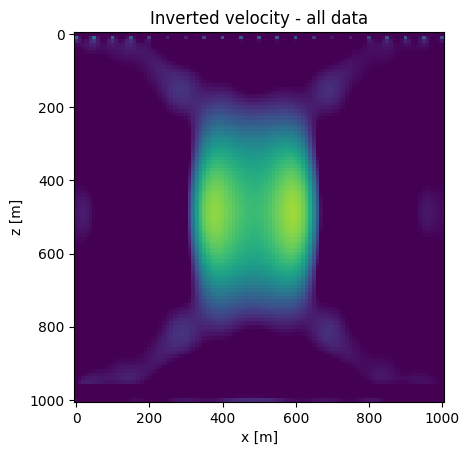

        10         13         31     5.00000e-01     1.83365e+03     4.82488e+03     1.24577e-01


In [6]:
max_func_evals = 30

# Construct objective function 
obj_func = construct_pde_misfit(v,Q,D,model,opts,batch_mode=false)
g = zeros(length(v))
obj(x) = (f = obj_func(x, g); return f, g)

# Project on to bound constraints
proj(x) = median([minimum(v).*ones(length(v)) x maximum(v).*ones(length(v))]; dims=2)

# Solve with SPG
sol = minConf_SPG(obj,vec(v0), proj, spg_options(verbose=3, maxIter=10))

plot_velocity(sol.sol,"Inverted velocity - all data",model)

Running SPG...
Number of objective function to store: 2
Using  spectral projection : true
Maximum number of function evaluations: 10
SPG optimality tolerance: 1.00e-05
SPG progress tolerance: 1.00e-07
 Iteration   FunEvals Projections     Step Length           alpha    Function Val        Opt Cond
         0          0          0     0.00000e+00     0.00000e+00     3.70709e+03     5.95603e-02
Halving Step Size
Halving Step Size
         1          4          4     2.50000e-01     1.87095e+03     3.37705e+03     9.47978e-02
         2          5          7     1.00000e+00     3.20980e+02     2.85583e+03     5.88659e-02
         3          6         10     1.00000e+00     2.13531e+02     2.49073e+03     5.79620e-02
         4          7         13     1.00000e+00     2.07413e+02     2.28614e+03     4.62027e-02
         5          8         16     1.00000e+00     4.79135e+02     1.99525e+03     5.36038e-02
         6          9         19     1.00000e+00     1.88885e+03     1.71272e+03   

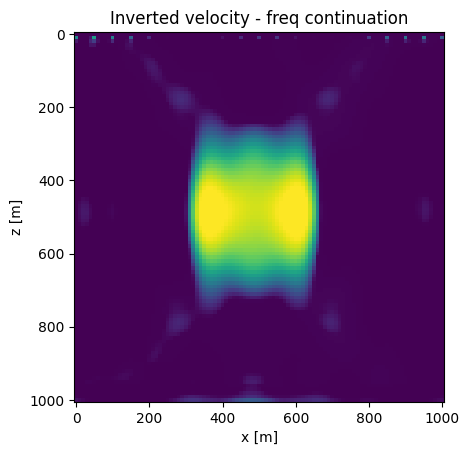

        10         18         31     1.25000e-01     1.50561e+03     7.28698e+02     8.06563e-02


In [7]:
# Frequency continuation 
size_freq_batch = 2
overlap = 1
freq_partition = partition(nfreq,size_freq_batch,overlap)
vest = v0
opts1 = deepcopy(opts);

for j in 1:size(freq_partition,2)
    fbatch = freq_partition[:, j]
    srcfreqmask = falses(nsrc, nfreq)
    srcfreqmask[:, fbatch] .= true
    opts1.srcfreqmask = srcfreqmask
    obj_func = construct_pde_misfit(v, Q, D, model, opts1, batch_mode=false)
    g = zeros(length(v))
    obj(x) = (f = obj_func(x, g); return f, g)
    sol = minConf_SPG(obj, vest, proj,spg_options(verbose=3, maxIter=10))
    vest = sol.sol
end
plot_velocity(vest,"Inverted velocity - freq continuation",model)